# Time series
---  
*J. Michelle Hu  
University of Utah  
Aug 2024*  


In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import geopandas as gpd
import xarray as xr
# import hvplot.xarray

from s3fs import S3FileSystem, S3Map

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

In [2]:
%reload_ext autoreload
%autoreload 2

### Env setup

In [3]:
from pathlib import PurePath
# Locate pyproj_datadir for studio env
# From https://stackoverflow.com/questions/69630630/on-fresh-conda-installation-of-pyproj-pyproj-unable-to-set-database-path-pypr
CONDA_ENV = 'studio'
miniconda_dir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3'
proj_version = h.fn_list(miniconda_dir, f'envs/{CONDA_ENV}/conda-meta/proj-[0-9]*.json')[0]

VERSION = PurePath(proj_version).stem
# print(proj_version)
# print(VERSION)

# /uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj
pyprojdatadir = f'{miniconda_dir}/pkgs/{VERSION}/share/proj'
print(pyprojdatadir)
pyproj.datadir.set_data_dir(pyprojdatadir)

# # Set environmental variable for PROJ to directory where you can find proj.db
# os.environ['PROJ']=pyprojdatadir
# os.environ['PROJLIB']=pyprojdatadir

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj


### Directories and global variables

In [4]:
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/'
# snotel_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL'
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts'
poly_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/polys'
aso_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/ASO'

# SNOTEL all sites geojson fn - snotel site json
allsites_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/snotel_sites_32613.json'
# nwm proj4 file
proj_fn = "/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/NWM_datasets_proj4.txt"

In [5]:
# Basin-specific variables
basin = 'blue'

In [6]:
# basindirs = h.fn_list(workdir, f'__{basin}*')
# basindirs = [h.fn_list(workdir, f'__{basin}*')[1], h.fn_list(workdir, f'{basin}*')[0]]
basindirs = [h.fn_list(workdir, f'*{basin}*')[1], h.fn_list(workdir, f'*{basin}*')[0]] # Blue River
basindirs

['/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_river_100m_isnobal',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/__blue_river_100m_isnobal_solar_albedo']

In [7]:
# Get the WY from the directory name - assumes there is only one WY per basin
WY = int(h.fn_list(basindirs[0], '*')[0].split('/')[-1].split('wy')[-1])
print(WY)

# Figure out filenames
# Basin polygon file if not in poly_dir, all should now be there
# poly_fn = h.fn_list(script_dir, f'*{basin}*setup/polys/*shp')[0]
poly_fn = h.fn_list(poly_dir, f'*{basin}*shp')[0]
print(poly_fn)

2019
/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/polys/blue_river_basin_outline_HUC10dissolved_32613.shp


### SNOTEL extraction and point specification
- identify SNOTEL sites within the specified basin
- extract site metadata (site name, site number, and coordinates)
- extract snow depth values for WY of interest

In [8]:
# Locate SNOTEL sites within basin
found_sites = proc.locate_snotel_in_poly(poly_fn=poly_fn, site_locs_fn=allsites_fn)

# Get site names and site numbers
sitenames = found_sites['site_name']
sitenums = found_sites['site_num']
print(sitenames)

155    Copper Mountain (415)
167       Fremont Pass (485)
170       Grizzly Peak (505)
Name: site_name, dtype: object


In [9]:
def get_snotel(sitenum, sitename, ST, WY, epsg=32613):
    '''Use metloom to pull snotel coordinates and return as geodataframe and daily data as dict of dataframes'''
    from metloom.pointdata import SnotelPointData
    import geopandas as gpd
    from shapely.geometry import Point
    from datetime import datetime
    
    # start and end date
    start_date = datetime(WY-1, 10, 1)
    end_date = datetime(WY, 9, 30)

    snotel_dfs = dict()
    snotellats = []
    snotellons = []
    for snotelNUM, snotelNAME, snotelST in zip(sitenum, sitename, ST):
        snotel_point = SnotelPointData(f"{snotelNUM}:{snotelST}:SNTL", f"{snotelNAME}")

        meta_df = snotel_point.metadata
        lon, lat = meta_df.x, meta_df.y
        snotellats.append(lat)
        snotellons.append(lon)
        
        # set up variable list
        variables = [snotel_point.ALLOWED_VARIABLES.SNOWDEPTH]

        # request the data - use daily, the hourly data is too noisy and messes up SDD calcs
        df = snotel_point.get_daily_data(start_date, end_date, variables)
        # df = snotel_point.get_hourly_data(start_date, end_date, variables)

        # Convert to metric here
        df['SNOWDEPTH_m'] = df['SNOWDEPTH'] * 0.0254
        
        # Reset the index 
        df = df.reset_index().set_index("datetime")

        # Store in dict
        snotel_dfs[snotelNAME] = df
    
    # Create a Geoseries based off of a list of a Shapely point using the lat and lon from the SNOTEL site
    s = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(snotellons, snotellats)])

    # Turn this into a geodataframe and specify the geom as the geoseries of the SNOTEL point
    gdf = gpd.GeoDataFrame(geometry=s)

    # Set the CRS inplace
    gdf.set_crs('epsg:4326', inplace=True)

    # Convert snotel coords' lat lon to UTM
    gdf = gdf.to_crs(f'epsg:{epsg}')

    return gdf, snotel_dfs

In [10]:
ST_arr = ['CO'] * len(sitenums)
gdf_metloom, snotel_dfs = get_snotel(sitenums, sitenames, ST_arr, WY=WY)
gdf_metloom

,geometry
0,POINT (399255.157 4371717.635)
1,POINT (396832.750 4359646.780)
2,POINT (425406.434 4388880.047)


In [11]:
snotel_dfs[sitenames.iloc[0]]

,site,geometry,SNOWDEPTH,SNOWDEPTH_units,datasource,SNOWDEPTH_m
datetime,,,,,,
2018-10-01 08:00:00+00:00,415:CO:SNTL,POINT Z (-106.17154 39.48917 10523.00000),0.0,in,NRCS,0.0
2018-10-02 08:00:00+00:00,415:CO:SNTL,POINT Z (-106.17154 39.48917 10523.00000),0.0,in,NRCS,0.0
2018-10-03 08:00:00+00:00,415:CO:SNTL,POINT Z (-106.17154 39.48917 10523.00000),0.0,in,NRCS,0.0
2018-10-04 08:00:00+00:00,415:CO:SNTL,POINT Z (-106.17154 39.48917 10523.00000),0.0,in,NRCS,0.0
2018-10-05 08:00:00+00:00,415:CO:SNTL,POINT Z (-106.17154 39.48917 10523.00000),0.0,in,NRCS,0.0
...,...,...,...,...,...,...
2019-09-26 08:00:00+00:00,415:CO:SNTL,POINT Z (-106.17154 39.48917 10523.00000),0.0,in,NRCS,0.0
2019-09-27 08:00:00+00:00,415:CO:SNTL,POINT Z (-106.17154 39.48917 10523.00000),0.0,in,NRCS,0.0
2019-09-28 08:00:00+00:00,415:CO:SNTL,POINT Z (-106.17154 39.48917 10523.00000),0.0,in,NRCS,0.0


<Axes: xlabel='datetime'>

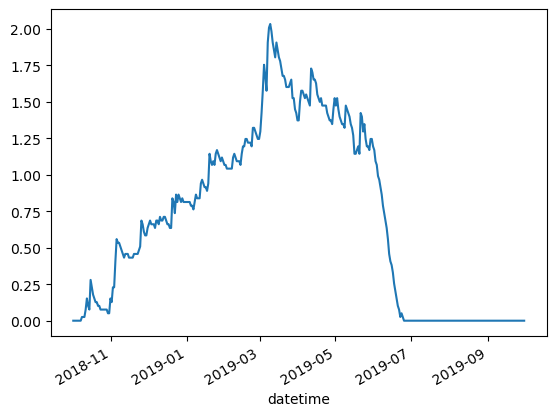

In [12]:
snotel_dfs[sitenames.iloc[0]]["SNOWDEPTH_m"].plot()

### NWM

In [13]:
# Read in NWM proj4 string
with open(proj_fn, "r") as f:
    proj4 = f.read()
proj4

'+proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs'

In [14]:
# Convert snotel points to NWM projection to extract time series
gdf_metloom_nwm = gdf_metloom.to_crs(crs=proj4)
gdf_metloom_nwm.bounds

,minx,miny,maxx,maxy
0,-762539.268202,-11409.052112,-762539.268202,-11409.052112
1,-766065.695077,-22853.588347,-766065.695077,-22853.588347
2,-735646.339191,2636.642421,-735646.339191,2636.642421


In [15]:
# Use gdf_metloom in nwm coords to extract NWM data
nwm_ds = proc.get_nwm_retrospective_LDAS(gdf_metloom_nwm, 
                                         start=f'{WY-1}-10-01', 
                                         end=f'{WY}-09-30', var='SNOWH')

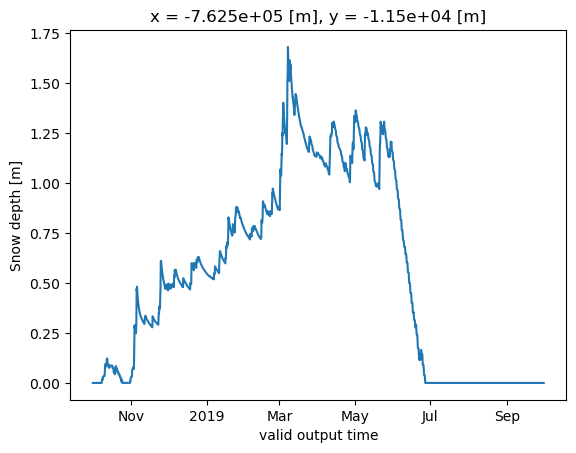

In [16]:
nwm_ds[0].plot()

### iSnobal output extraction

- iSnobal time decay
- iSnobal MODIS-HRRR

In [17]:
%%time
# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
month = 'run20'
varname = 'snow'
days = h.fn_list(basindirs[0], f"*/*/{month}*/{varname}.nc")
days = [days, h.fn_list(basindirs[1], f"*/*/{month}*/{varname}.nc")]

print(len(days[0]), len(days[1]))

365 365
CPU times: user 29.1 ms, sys: 128 ms, total: 157 ms
Wall time: 17.9 s


In [18]:
%%time

chunks = 'auto'
drop_var_list = ['snow_density', 'specific_mass', 'liquid_water', 'temp_surf', 'temp_lower', 'temp_snowcover', 'thickness_lower', 'water_saturation', 'projection']


ds_list = [xr.open_dataset(day_fn, chunks=chunks, drop_variables=drop_var_list) for day_fn in days[0]]
ds_sol_list = [xr.open_dataset(day_fn, chunks=chunks, drop_variables=drop_var_list) for day_fn in days[1]]

snow_var_data = [ds.sel(x=list(gdf_metloom.geometry.x.values), y=list(gdf_metloom.geometry.y.values), method='nearest') for ds in ds_list]
snow_updated_var_data = [ds.sel(x=list(gdf_metloom.geometry.x.values), y=list(gdf_metloom.geometry.y.values), method='nearest') for ds in ds_sol_list]

# Concatenate all the days
depth_ts = xr.concat(snow_var_data, dim='time')
depth_sol_ts = xr.concat(snow_updated_var_data, dim='time')

# do some cleanup
del ds_list, ds_sol_list, snow_var_data, snow_updated_var_data

depth_sol_ts

CPU times: user 16.2 s, sys: 4.74 s, total: 21 s
Wall time: 1min 12s


<xarray.Dataset> Size: 16kB
Dimensions:    (time: 365, y: 3, x: 3)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2018-10-01T22:00:00 ... 2019-09-30T2...
  * y          (y) float32 12B 4.372e+06 4.36e+06 4.389e+06
  * x          (x) float32 12B 3.993e+05 3.968e+05 4.254e+05
Data variables:
    thickness  (time, y, x) float32 13kB dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
Attributes:
    last_modified:  [2024-08-12 11:34:52] Data added or updated

In [19]:
# %%time
# # try the mf option - takes ~30 seconds
# ds_list = xr.open_mfdataset(days[0], parallel=True, chunks=chunks, drop_variables=drop_var_list)
# ds_sol_list = xr.open_mfdataset(days[1], parallel=True, chunks=chunks, drop_variables=drop_var_list)

# snow_var_data = ds_list.sel(x=list(gdf_metloom.geometry.x.values), y=list(gdf_metloom.geometry.y.values), method='nearest')
# snow_updated_var_data = ds_sol_list.sel(x=list(gdf_metloom.geometry.x.values), y=list(gdf_metloom.geometry.y.values), method='nearest')
# snow_updated_var_data

### ASO value extraction

In [20]:
# Locate ASO snow dpeth files
state = 'CO'

# from https://nsidc.org/sites/nsidc.org/files/technical-references/ASO_Basins.pdf
# only blue river basin has different names
basin_name = basin.capitalize() # more recent collections
basin_name = 'USCOBR' # older collections from NSIDC

# Water year collections should all be post January so this should work
# depth_fns = h.fn_list(aso_dir, f'{state}/*{basin_name}*{WY}*tif')
depth_fns = h.fn_list(aso_dir, f'{state}/*{basin_name}*snowdepth*tif')
if len(depth_fns) == 0:
    depth_fns = h.fn_list(aso_dir, f'{state}/*{basin_name}*/*{basin_name}*snowdepth*tif')
    if len(depth_fns) == 0:
        depth_fns = h.fn_list(aso_dir, f'{state}/*{basin_name}*tif')
print(depth_fns)

['/uufs/chpc.utah.edu/common/home/skiles-group3/ASO/CO/ASO_50M_SD_USCOBR_20190419.tif', '/uufs/chpc.utah.edu/common/home/skiles-group3/ASO/CO/ASO_50M_SD_USCOBR_20190624.tif']


In [21]:
# Load depth arrays and squeeze out single dimensions
depth_list = [np.squeeze(xr.open_dataset(fn)) for fn in depth_fns]

# Rename band_data to be more descriptive
depth_list = [ds.rename_vars({'band_data': 'snow_depth'}) for ds in depth_list]

# Deal with adding time input for ASO data
inputvar = '.'
depth_list = [proc.assign_dt(ds, proc.extract_dt(fn, inputvar=inputvar)) for ds, fn in zip(depth_list, depth_fns)]

# Get dates, could easily just pull from filenames, but this is fine
date_list = [proc.extract_dt(fn, inputvar=inputvar)[0] for fn in depth_fns]
date_list = [f.strftime('%Y%m%d') for f in date_list]
print(date_list)

# ASO is in EPSG 32613 for USCOBR, same as gdf_metloom. Should be good to go
print(depth_list[0].rio.crs)

['20190419', '20190624']
EPSG:32613


In [22]:
%%time
# Extract ASO snow depth value with NN lookup at snotel sites
aso_sd_point_list = [] 

for ds in depth_list:
    # Extract data value from this point based on nearest neighbor lookup (inexact)
    # Coords must be bracketed
    aso_sd_point = ds['snow_depth'].sel(x=list(gdf_metloom.geometry.x.values),
                                       y=list(gdf_metloom.geometry.y.values), 
                                       method='nearest')
    aso_sd_point_list.append(aso_sd_point)

# Concatenate the list of data arrays into a single dataarray based on time dimension
aso_depth_ts = xr.concat(aso_sd_point_list, dim='time')
aso_depth_ts

CPU times: user 5.92 ms, sys: 685 μs, total: 6.61 ms
Wall time: 6.06 ms


<xarray.DataArray 'snow_depth' (time: 2, y: 3, x: 3)> Size: 72B
array([[[1.3778149 , 1.6561947 ,        nan],
        [       nan,        nan,        nan],
        [       nan,        nan, 0.98238415]],

       [[0.20729493, 0.25887528,        nan],
        [0.03578551, 0.230275  ,        nan],
        [       nan,        nan, 0.04190773]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 16B 2019-04-19 2019-06-24
    band         int64 8B 1
  * x            (x) float64 24B 3.993e+05 3.969e+05 4.254e+05
  * y            (y) float64 24B 4.372e+06 4.36e+06 4.389e+06
    spatial_ref  int64 8B 0
Attributes:
    Band_1:         ASO SUPER snow depth [m]
    AREA_OR_POINT:  Area
    long_name:      ASO SUPER snow depth [m]

### Extract into individual time series

In [23]:
%%time
aso_site_ts_list = []
for jdx, sitenum in enumerate(sitenums):
    # print(jdx)
    aso_site_ts = aso_depth_ts[:, jdx, jdx]
    aso_site_ts_list.append(aso_site_ts)

# Generate dates for ASO data dataframe
aso_dt_list = [depth['time'].values[0] for depth in aso_sd_point_list]

# Put the extracted depths into a dataframe
aso_depth_ts_df = pd.DataFrame(data=np.array(aso_site_ts_list).T, columns=sitenames, index=aso_dt_list)
aso_depth_ts_df

CPU times: user 1.21 ms, sys: 64 μs, total: 1.27 ms
Wall time: 1.29 ms


site_name,Copper Mountain (415),Fremont Pass (485),Grizzly Peak (505)
2019-04-19,1.377815,NaN,0.982384
2019-06-24,0.207295,0.230275,0.041908


<Axes: >

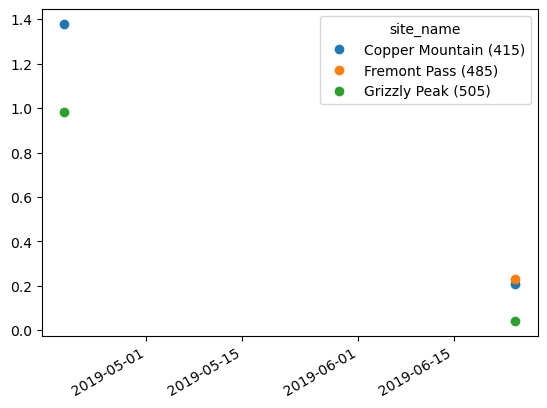

In [24]:
aso_depth_ts_df.plot(marker='o', linewidth=0)

## Plot

#### Calculate snow disappearance date separately to plot and re-plot quickly

In [36]:
# Disappearance date parameters
snow_name = 'Snow Depth'
verbose = False
day_thresh = 3

In [37]:
%%time
sdd_list = []
for jdx, (sitenum, sitename) in enumerate(zip(sitenums, sitenames)):
    # Extract SNOTEL data for this site
    snotel_df = snotel_dfs[sitename]
    print(f'\n{sitename}')

    # Extract model data for this site
    isnobal_hrrr_ts = depth_ts['thickness'][:, jdx, jdx]
    modis_hrrr_ts = depth_sol_ts['thickness'][:, jdx, jdx]

    # Extract ASO data for this site
    aso_depth_ts = aso_depth_ts_df[sitename]

    # Calculate disappearance dates
    snotel_sdd, _ = proc.calc_sdd(snotel_df['SNOWDEPTH_m'], 
                                snow_name=snow_name, 
                                verbose=verbose, 
                                day_thresh=day_thresh)
    print(f'SNOTEL: {snotel_sdd}')
    
    # Convert model data to Pandas Series
    classic_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(isnobal_hrrr_ts.data), index=isnobal_hrrr_ts.time.values),
                                snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
    print(f'Time Decay: {classic_sdd}')

    # Convert model data to Pandas Series
    modis_hrrr_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(modis_hrrr_ts.data), index=modis_hrrr_ts.time.values),
                                snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
    print(f'MODIS-HRRR: {modis_hrrr_sdd}')

    # Resample NWM data to daily timestep to smooth hourly blips for SDD calc
    nwm_daily = nwm_ds[jdx].resample(time='D').mean()
    nwm_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(nwm_daily.data), index=nwm_daily.time.values),
                                    snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)

    print(f'NWM: {nwm_sdd}')
    
    sdd_list.append([snotel_sdd, classic_sdd, modis_hrrr_sdd, nwm_sdd])


Copper Mountain (415)
SNOTEL: 2019-06-22 08:00:00+00:00
Time Decay: 2019-07-05 22:00:00
MODIS-HRRR: 2019-06-02 22:00:00
NWM: 2019-06-27 00:00:00

Fremont Pass (485)
SNOTEL: 2019-07-06 08:00:00+00:00
Time Decay: 2019-07-14 22:00:00
MODIS-HRRR: 2019-06-25 22:00:00
NWM: 2019-07-05 00:00:00

Grizzly Peak (505)
SNOTEL: 2019-06-21 08:00:00+00:00
Time Decay: 2019-06-20 22:00:00
MODIS-HRRR: 2019-06-29 22:00:00
NWM: 2019-07-04 00:00:00
CPU times: user 329 ms, sys: 801 μs, total: 330 ms
Wall time: 331 ms


In [44]:
# # Plotting things
# linestyles = ['-', '--']
# linewidth = 1.5
# marker = None

# snotelcolor = 'dimgray'
# isnobalcolors = ['mediumblue', 'cornflowerblue']
# nwm_color = 'salmon'#'tomato'
# alpha = 0.7
# isnobal_alpha = 0.6

# figsize = (8, 4)
# fig, ax = plt.subplots(1, figsize=figsize)
# # Plot WY time series of snow depth
# snotel_df['SNOWDEPTH_m'].plot(ax=ax,
#                                 label=f'SNOTEL',
#                                 # linestyle=(0, (3, 1, 1, 1, 1, 1)),
#                                 linewidth=linewidth/3,
#                                 color=snotelcolor,
#                                 marker='.', 
#                                 markersize=3,
#                                 # alpha=alpha
#                                 )

# isnobal_hrrr_ts.plot(ax=ax, color=isnobalcolors[0], label='iSnobal-HRRR', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)
# modis_hrrr_ts.plot(ax=ax, color=isnobalcolors[1], label='MODIS-HRRR', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)

# nwm_ds[jdx].plot(ax=ax, color=nwm_color, label='NWM', linewidth=linewidth/2, 
#                linestyle='--', 
#             #    alpha=alpha
#                )

# aso_depth_ts_df[sitenames.iloc[jdx]].plot(ax=ax, marker='o', linewidth=0, label='ASO')
# sdds = sdd_list[jdx]
# snotel_sdd, classic_sdd, modis_hrrr_sdd, nwm_sdd = sdds 

# # Add callouts of disappearance dates with vertical lines
# plt.axvline(snotel_sdd, color=snotelcolor, linestyle='--', linewidth=0.75, label='SNOTEL SDD')
# plt.axvline(classic_sdd, color=isnobalcolors[0], linestyle='--', linewidth=0.75, label='iSnobal-HRRR SDD')
# plt.axvline(modis_hrrr_sdd, color=isnobalcolors[1], linestyle='--', linewidth=0.75, label='MODIS-HRRR SDD')
# plt.axvline(nwm_sdd, color=nwm_color, linestyle='--', linewidth=0.75, label='NWM SDD')

# # Add arrows pointing left towards the vertical lines above, in the same color as the line
# # get fraction of max y value for the y position of the arrow
# ymax = ax.get_ylim()[1]

# plt.annotate(f'{snotel_sdd.strftime("%Y-%m-%d")}', xy=(snotel_sdd, ymax*0.2), xytext=(snotel_sdd, ymax*0.3),
#             color=snotelcolor, arrowprops=dict(color=snotelcolor, arrowstyle='->'))
# plt.annotate(f'{classic_sdd.strftime("%Y-%m-%d")}', xy=(classic_sdd, ymax*0.8), xytext=(classic_sdd, ymax*0.9),
#             color=isnobalcolors[0], arrowprops=dict(color=isnobalcolors[0], arrowstyle='->'))
# plt.annotate(f'{modis_hrrr_sdd.strftime("%Y-%m-%d")}', xy=(modis_hrrr_sdd, ymax*0.6), xytext=(modis_hrrr_sdd, ymax*0.7),
#             color=isnobalcolors[1], arrowprops=dict(color=isnobalcolors[1], arrowstyle='->'))
# plt.annotate(f'{nwm_sdd.strftime("%Y-%m-%d")}', xy=(nwm_sdd, ymax*0.4), xytext=(modis_hrrr_sdd, ymax*0.5),
#             color=nwm_color, arrowprops=dict(color=nwm_color, arrowstyle='->'))
    
# plt.legend(bbox_to_anchor=(1,1), alignment='center')
# # plt.legend(bbox_to_anchor=(1,-0.1), ncol=4, alignment='center')
# plt.title(f'{sitename} Snow Depth')
# plt.xlabel('');



In [45]:
# Load all the arrays for quick plotting
depth_ts.load()
depth_sol_ts.load()

for ds in nwm_ds:
    ds.load()

In [47]:
# Plotting params
linestyles = ['-', '--']
linewidth = 1.5

snotelcolor = 'dimgray'
isnobalcolors = ['mediumblue', 'cornflowerblue']
nwm_color = 'salmon'#'tomato'
alpha = 0.7
isnobal_alpha = 0.6

figsize = (8, 4)


In [48]:
import seaborn as sns
sns.set_palette("icefire")

In [61]:
snotel_sdd +  pd.Timedelta(days=30)

Timestamp('2019-07-21 08:00:00+0000', tz='UTC')


Copper Mountain (415)

Fremont Pass (485)

Grizzly Peak (505)


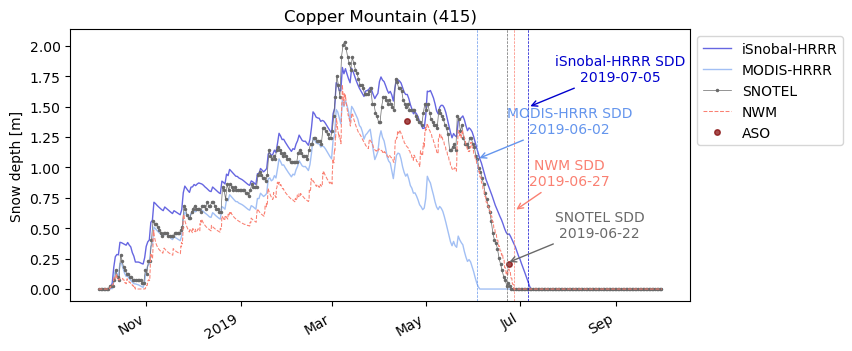

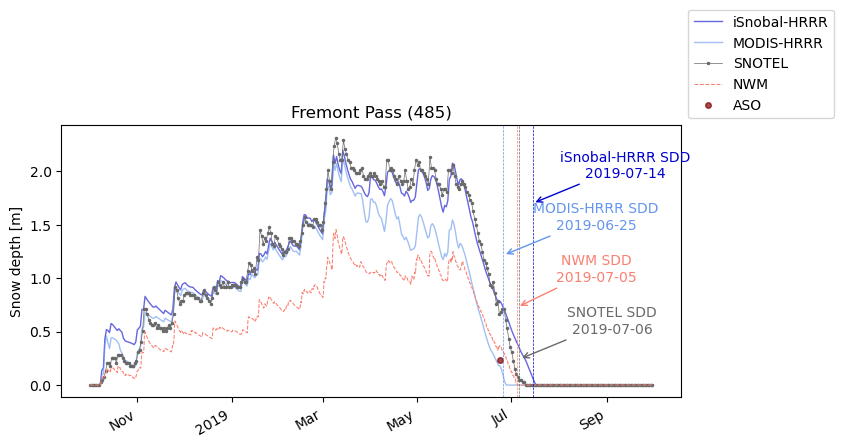

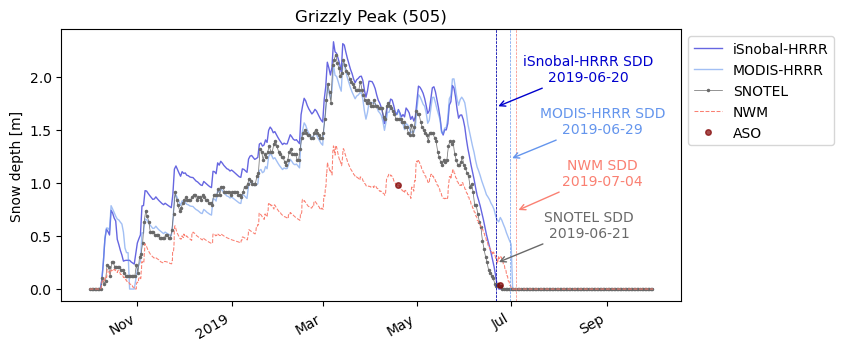

In [87]:
for jdx, (sitenum, sitename, sdds) in enumerate(zip(sitenums, sitenames, sdd_list)):
    # Extract SNOTEL data for this site
    snotel_df = snotel_dfs[sitename]
    print(f'\n{sitename}')

    # Extract model data for this site
    isnobal_hrrr_ts = depth_ts['thickness'][:, jdx, jdx]
    modis_hrrr_ts = depth_sol_ts['thickness'][:, jdx, jdx]

    # Extract ASO data for this site
    aso_depth_ts = aso_depth_ts_df[sitename]

    # Calculate disappearance dates
    snotel_sdd, classic_sdd, modis_hrrr_sdd, nwm_sdd = sdds 

    fig, ax = plt.subplots(1, figsize=figsize)

    isnobal_hrrr_ts.plot(ax=ax, color=isnobalcolors[0], label='iSnobal-HRRR', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)
    modis_hrrr_ts.plot(ax=ax, color=isnobalcolors[1], label='MODIS-HRRR', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)

    # Plot WY time series of snow depth
    snotel_df['SNOWDEPTH_m'].plot(ax=ax, label=f'SNOTEL',
                                    # linestyle=(0, (3, 1, 1, 1, 1, 1)),
                                    linewidth=linewidth/3,
                                    color=snotelcolor, marker='.', markersize=3,
                                    )
    
    nwm_ds[jdx].plot(ax=ax, color=nwm_color, label='NWM', linewidth=linewidth/2, linestyle='--')
    
    aso_depth_ts_df[sitenames.iloc[jdx]].plot(ax=ax, marker='o', markersize=4, linewidth=0, label='ASO', color='maroon', alpha=alpha)

    plt.legend(bbox_to_anchor=(1,1), alignment='center')
    # plt.legend(bbox_to_anchor=(1,-0.1), ncol=4, alignment='center')
    plt.title(f'{sitename}')
    plt.xlabel('');
    
    # Add callouts of disappearance dates with vertical lines
    vlinestyle = '--'
    vlinewidth = 0.5
    plt.axvline(snotel_sdd, color=snotelcolor, linestyle=vlinestyle, linewidth=vlinewidth, label='SNOTEL SDD')
    plt.axvline(classic_sdd, color=isnobalcolors[0], linestyle=vlinestyle, linewidth=vlinewidth, label='iSnobal-HRRR SDD')
    plt.axvline(modis_hrrr_sdd, color=isnobalcolors[1], linestyle=vlinestyle, linewidth=vlinewidth, label='MODIS-HRRR SDD')
    plt.axvline(nwm_sdd, color=nwm_color, linestyle=vlinestyle, linewidth=vlinewidth, label='NWM SDD')

    # Add arrows pointing left towards the vertical lines above, in the same color as the line
    # get fraction of max y value for the y position of the arrow
    ymax = ax.get_ylim()[1]

    timedelta = pd.Timedelta(days=30)
    timedelta_text = pd.Timedelta(days=60)
    plt.annotate(f'SNOTEL SDD\n{snotel_sdd.strftime("%Y-%m-%d")}', xy=(snotel_sdd, ymax*0.1), xytext=(snotel_sdd + timedelta_text, ymax*0.2),
                color=snotelcolor, arrowprops=dict(color=snotelcolor, arrowstyle='->'), ha='center')
    plt.annotate(f'iSnobal-HRRR SDD\n{classic_sdd.strftime("%Y-%m-%d")}', xy=(classic_sdd, ymax*0.7), xytext=(classic_sdd + timedelta_text, ymax*0.8),
                color=isnobalcolors[0], arrowprops=dict(color=isnobalcolors[0], arrowstyle='->'), ha='center')
    plt.annotate(f'MODIS-HRRR SDD\n{modis_hrrr_sdd.strftime("%Y-%m-%d")}', xy=(modis_hrrr_sdd, ymax*0.5), xytext=(modis_hrrr_sdd + timedelta_text, ymax*0.6),
                color=isnobalcolors[1], arrowprops=dict(color=isnobalcolors[1], arrowstyle='->'), ha='center')
    plt.annotate(f'NWM SDD\n{nwm_sdd.strftime("%Y-%m-%d")}', xy=(nwm_sdd, ymax*0.3), xytext=(modis_hrrr_sdd + timedelta_text, ymax*0.4),
                color=nwm_color, arrowprops=dict(color=nwm_color, arrowstyle='->'), ha='center')